# Quantized Neural Network
## 04- Custom Gradients
by [Soon Yau Cheong](http://www.linkedin.com/in/soonyau)

In last tutorial, we learned about how to quantize a Tensorflow graph and add operations for quantization aware training. Before going to do a training, in this tutorial we'll study the uniquness of gradients in quantized network and learn a new kind of gradient for backpropagation.

In [3]:
import os
import sys
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt

import utils

print("Tensorflow", tf.__version__)
print("Python", sys.version)

Tensorflow 1.10.0
Python 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


## Vanishing and Exploding Gradients
We are almost ready to actually start training quantized network and there is only one more thing to mention - the gradient. In fact any discussion on QNN will not complete without mentioning the fancy word Straight Through Estimator (STE).

I assume  you are familiar with backpropagation and gradient descent. In the training, the gradients of network output error is traversed backward to the parameters. For that to works, the functions have to be differentiable i.e. its derivative exists but this is not the case for quantization. As shown below, the quantization plot looks like a staircase with discrete steps. For region where the function is a horizontal line which is almost everywhere, the gradient is 0. As a result, any error backprop to here will become zero (anything multiply by zero is zero) and therefore the weights don't receive gradient for update in the training. On the other hand, at the vertical line where the step happens, the gradient is infinity. 

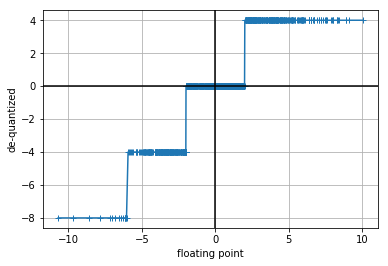

In [4]:
np.random.seed(1515)
input_dim = [1, 1000]
x = np.sort(3*np.random.randn(1000).astype(np.float32)).reshape(input_dim)

tf.reset_default_graph()
num_bits = 2
input = tf.placeholder(tf.float32, input_dim)

# gradient functions will be described below
output = tf.fake_quant_with_min_max_vars(input, min=-6.0, max=6.0, num_bits=num_bits)
grad = tf.fake_quant_with_min_max_vars_gradient(output, input, min=-6.0, max=6.0, num_bits=num_bits)
grad_func = tf.gradients(output, input)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    [x_quant, gradients, gradients_func] = sess.run(\
                                                      [output, grad, grad_func], \
                                                      feed_dict={input:x})

fig, ax = plt.subplots()

ax.plot(x.reshape(-1), x_quant.reshape(-1), '-o', marker='+',)
ax.set_xlabel("floating point")
ax.set_ylabel("de-quantized")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)


In example above, I used only 2-bits quantization to make the steps look more dramatic. If we look at the y-axis, the minimum quantized value is -8 which is not the minimum -6.0 we set. Since we want to make sure 0 is quantized to 0, therefore the 4 discrete values are (-8, -4, 0, 4) and the min and max are shifted by 2 to negative direction. These are some minor details to watch out for when using very small number of bits for quantization.

## Straight Through Estimator (STE)

To overcome this problem, Straight Through Estimator (STE) is used as the gradient function. Despite of the fancy name, it really is just an identity function that pass the incoming gradient straight through as it is if it fall within min-max-range, otherwise zeros. To put into the quantization context, that effectively assume that the fake quantization is equal to the original values. 

There are a few TF functions with regards to gradients for quantization. Let's introduce them briefly here.

__tf.gradients__(y,x) return the partial derivative function of y with respect to x. If we print out the gradient function using tf.gradients, we'll see that there is a FakeQuantWithMinMaxVarsGradient operator. 

In [5]:
print(grad_func)

[<tf.Tensor 'gradients/FakeQuantWithMinMaxVars_grad/FakeQuantWithMinMaxVarsGradient:0' shape=(1, 1000) dtype=float32>]


When we run TF session to read tf.gradients(), it will return numerical values that is to multiply with the errors flowing in from higher layer. In the code example above, we have already run the session to return the grad_fun. We print some of the values and plot it on graph, we'll see it is mostly 1.0 except for quantized values that is out of range.

Text(0, 0.5, 'gradient function')

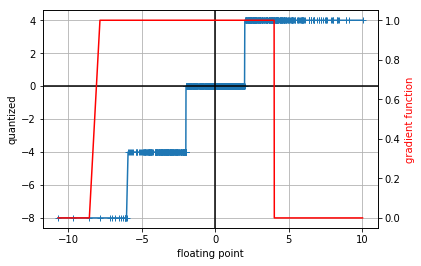

In [6]:
fig, ax = plt.subplots()

ax.plot(x.reshape(-1), x_quant.reshape(-1), '-o', marker='+',)
ax.set_xlabel("floating point")
ax.set_ylabel("quantized")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

ax2=ax.twinx()
ax2.plot(x.reshape(-1), np.array(gradients_func).reshape(-1), color='red')
ax2.set_ylabel('gradient function', color='r')

The last function is __tf.fake_quant_with_min_max_vars_gradient()__ which perform the backpropagation. In practice, all it does is to multiply the quantized value with the gradient function element wise as shown in plot below.

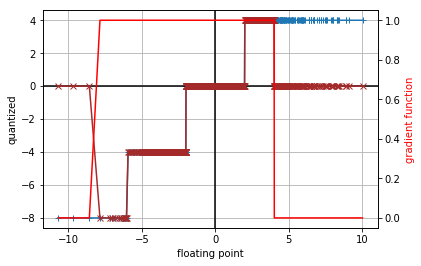

In [7]:
fig, ax = plt.subplots()

ax.plot(x.reshape(-1), x_quant.reshape(-1), '-o', marker='+',)
ax.set_xlabel("floating point")
ax.set_ylabel("quantized")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

ax2=ax.twinx()
ax2.plot(x.reshape(-1), np.array(gradients_func).reshape(-1), color='red')
ax2.set_ylabel('gradient function', color='r')

ax.plot(x.reshape(-1), np.array(gradients[0]).reshape(-1), color='brown', marker='x')


## Writing Custom Gradient Function

Sometimes researchers need to write some custom functions for experimentation. Sometimes you'll need to write custom gradient functions too, or override the default functions, say you want to create a leaky version that multiply the gradients by 0.9. Is that possible? Of course. I'll show you how to use function decorator @tf.custom_gradient to set the function gradient to your Python function. Now let's try to create our own fake quantization function.

Here I'll use two TF APIs __tf.quantize__ and __tf.dequantize__ which look like are for internal experimentation as you can only use the defined data type e.g. tf.qint8 rather than any arbitrary bitwidth. Anyway, this is enough to serve our purpose for now. Without too much work, we could translate the quantize-dequantize function we wrote in Tutorial 2, which I'll leave as exercise. 

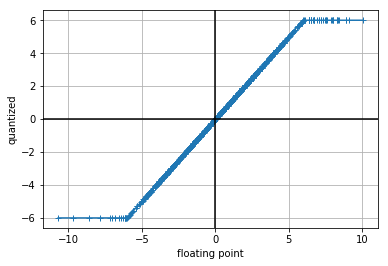

In [8]:
tf.reset_default_graph()

def my_fake_quant_with_min_max_vars(inputs, min, max, num_bits=8):

    quantized, quant_min, quant_max = tf.quantize(inputs, min, max, tf.quint8)
    cast_quantized = tf.cast(quantized, tf.quint8)
    dequantized = tf.dequantize(quantized, quant_min, quant_max)
    
    return dequantized


my_input = tf.placeholder(tf.float32)
my_output = my_fake_quant_with_min_max_vars(my_input, min=-6.0, max=6.0, num_bits=8)

with tf.Session() as sess:
    x_quant = sess.run(my_output, feed_dict={my_input:x})
    
fig, ax = plt.subplots()

ax.plot(x.reshape(-1), x_quant.reshape(-1), '-o', marker='+',)
ax.set_xlabel("floating point")
ax.set_ylabel("quantized")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)

If we try run this line to read the gradient function, we'll be getting error because it is not defined
```
tf.gradients(my_output, my_input)
```
Now let's first go through how to use @tf.custom_gradient to add gradient to a function with multiply a tensor by itself. Therefore, the gradient of $x^2$ should therefore be $2x$ as confirmed below.


In [9]:
def my_function(x):
    return x*x

a = tf.constant(3.0)
c = my_function(a)
grad = tf.gradients(c, a)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(grad))


[6.0]


Now let's add the decorater @tf.custom_gradient and now the function is expected to return two things - the output tensor, and the gradient function.

In [10]:
@tf.custom_gradient
def my_function_grad(x):
    y = x*x 
    
    def grad(dy):
        return tf.identity(dy)
    
    return y, grad

a = tf.constant(3.0)
c = my_function_grad(a)
grad = tf.gradients(c, a)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(grad))

[1.0]


It is simple and elegant but we can't use it straight away to our problem. Although the decorated function can accept multiple tensors as input it cannot accept non-tensor type like num_bits. To work around this problem, we'll use a powerful Python library to first 'compile' the function with with non-tensors data that can be pre-determined in compile time, into a function with single tensor as input.

Text(0, 0.5, 'gradient function')

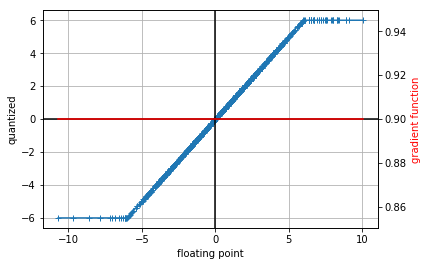

In [11]:
from functools import partial

tf.reset_default_graph()

def my_fake_quant_with_min_max_vars(inputs, min, max, num_bits=8):

    def _fake_quant(min, max, num_bits, inputs):
        quantized, quant_min, quant_max = tf.quantize(inputs, min, max, tf.quint8)
        cast_quantized = tf.cast(quantized, tf.quint8)
        dequantized = tf.dequantize(quantized, quant_min, quant_max)

        return dequantized
    
    # create a new function with fixed min, max, num_bits
    fake_quant = partial(_fake_quant, min, max, num_bits)
    
    @tf.custom_gradient
    def fake_quant_wrapper(x):
        y = fake_quant(x)
    
        # your custom gradient function here
        def grad(dy):
            return 0.9*tf.identity(dy)
    
        return y, grad
    
    return fake_quant_wrapper(inputs)

my_input = tf.placeholder(tf.float32)
my_output = my_fake_quant_with_min_max_vars(my_input, -6.0, 6.0, 8)
grad_func = tf.gradients(my_output, my_input)

with tf.Session() as sess:
    [x_quant, gradients_func] = sess.run([my_output, grad_func], feed_dict={my_input:x})

fig, ax = plt.subplots()    
ax.plot(x.reshape(-1), x_quant.reshape(-1), '-o', marker='+',)
ax.set_xlabel("floating point")
ax.set_ylabel("quantized")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
ax.grid(True)


ax2=ax.twinx()
ax2.plot(x.reshape(-1), np.array(gradients_func).reshape(-1), color='red')
ax2.set_ylabel('gradient function', color='r')

## What's Next?

We have learned everything we need to know for quantized neural network training. Next, we'll apply our new learned knowledge to actually train a MobileNet on Cifar10.